In [1]:
# %%
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel

# ---------- paths for Elastic Net (3 preprocessing methods)
LOG1P_FILE = "10_fold_pseudobulk_log1p_30_pcs_tissue_growth.csv"
SCRAN_FILE = "10_fold_pseudobulk_scran_30_pcs_tissue_growth.csv"
PEARSON_FILE = "10_fold_pseudobulk_pearson_residuals_30_pcs_tissue_growth.csv"

PATHS = {
    "log1p": f"01_simple_baselines/results/elastic_net/{LOG1P_FILE}",
    "scran": f"01_simple_baselines/results/elastic_net/{SCRAN_FILE}",
    "pearson": f"01_simple_baselines/results/elastic_net/{PEARSON_FILE}",
}

def load_results(path, label):
    df = pd.read_csv(path)
    # Normalize column names
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global":"r2_mean", "rmse":"rmse_mean"})
    needed = {"DRUG_ID","n_samples","r2_mean","rmse_mean",
              "pearson_r","pearson_pval","spearman_r","spearman_pval"}
    missing = sorted(list(needed - set(df.columns)))
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}")
    df["Preprocessing"] = label
    return df[["DRUG_ID","n_samples","r2_mean","rmse_mean",
               "pearson_r","pearson_pval","spearman_r","spearman_pval","Preprocessing"]]

frames = [load_results(p, m) for m,p in PATHS.items()]
df_all = pd.concat(frames, ignore_index=True)
print("✅ combined:", df_all.shape)
df_all.head()


✅ combined: (1875, 9)


,DRUG_ID,n_samples,r2_mean,rmse_mean,pearson_r,pearson_pval,spearman_r,spearman_pval,Preprocessing
0,133,132,0.124715,1.585180,0.359003,0.000024,0.342416,0.000058,log1p
1,134,132,0.068242,1.845981,0.262113,0.002397,0.276604,0.001325,log1p
2,135,131,0.063484,2.525975,0.252720,0.003589,0.278669,0.001268,log1p
3,136,133,0.071632,1.451900,0.275528,0.001328,0.202401,0.019470,log1p
4,140,133,0.063782,1.585237,0.266717,0.001914,0.312698,0.000248,log1p


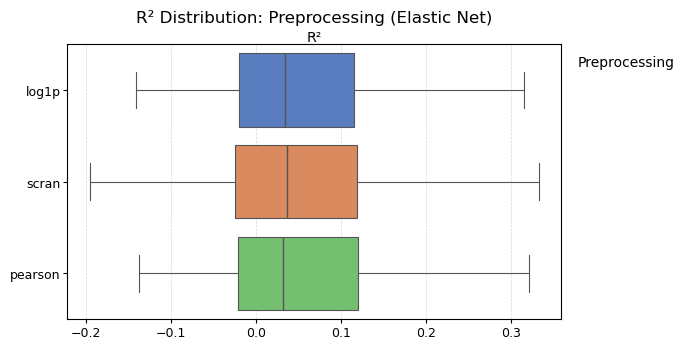

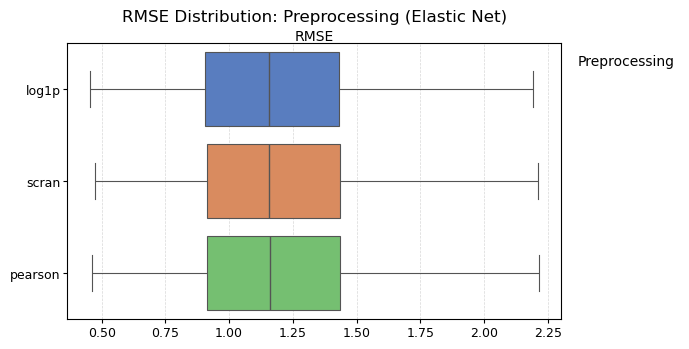

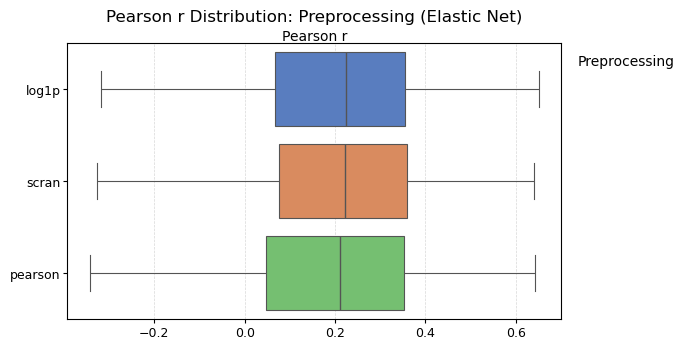

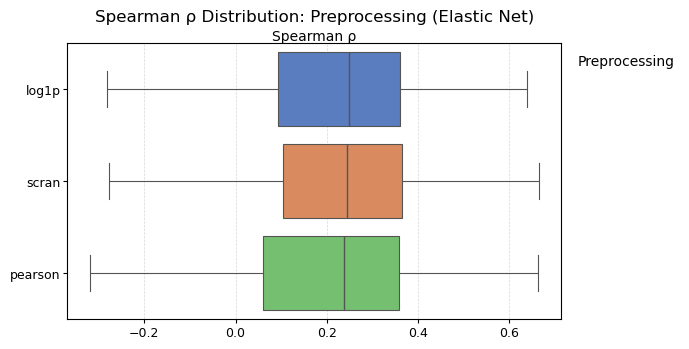

In [2]:
# %%
# %%
# boxplots (R², RMSE, Pearson r, Spearman ρ) comparing preprocessing methods
def nice_boxplot(df, x, title):
    fig, ax = plt.subplots(figsize=(7, 3.6))
    sns.boxplot(
        data=df, x=x, y="Preprocessing", hue="Preprocessing",
        palette="muted", showfliers=False, dodge=False, ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel({"r2_mean":"R²", "rmse_mean":"RMSE",
                   "pearson_r":"Pearson r","spearman_r":"Spearman ρ"}[x],
                   fontsize=10, labelpad=2)
    ax.set_ylabel("")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Preprocessing", frameon=False, loc="upper left",
              bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10)
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    plt.tight_layout(); plt.show()

nice_boxplot(df_all, "r2_mean",    "R² Distribution: Preprocessing (Elastic Net)")
nice_boxplot(df_all, "rmse_mean",  "RMSE Distribution: Preprocessing (Elastic Net)")
nice_boxplot(df_all, "pearson_r",  "Pearson r Distribution: Preprocessing (Elastic Net)")
nice_boxplot(df_all, "spearman_r", "Spearman ρ Distribution: Preprocessing (Elastic Net)")


In [3]:
# %%
# %% aggregate stats per preprocessing
def agg_stats(df, metric):
    g = df.groupby(["Preprocessing"], as_index=False)[metric].agg(mean="mean", std="std", n="count")
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g.rename(columns={"mean":"Mean","std":"Std","n":"N","ci95":"95% CI"})

summary_table = pd.concat([
    agg_stats(df_all, "r2_mean"),
    agg_stats(df_all, "rmse_mean"),
    agg_stats(df_all, "pearson_r"),
    agg_stats(df_all, "spearman_r"),
], ignore_index=True)

display(summary_table[["metric","Preprocessing","N","Mean","Std","95% CI"]].round(4))


,metric,Preprocessing,N,Mean,Std,95% CI
0,r2_mean,log1p,625,0.0588,0.1051,0.0082
1,r2_mean,pearson,625,0.0570,0.1056,0.0083
2,r2_mean,scran,625,0.0583,0.1093,0.0086
3,rmse_mean,log1p,625,1.1946,0.3751,0.0294
4,rmse_mean,pearson,625,1.1960,0.3768,0.0295
5,rmse_mean,scran,625,1.1946,0.3757,0.0295
6,pearson_r,log1p,625,0.2085,0.2008,0.0157
7,pearson_r,pearson,625,0.1969,0.2093,0.0164
8,pearson_r,scran,625,0.2087,0.2083,0.0163
9,spearman_r,log1p,625,0.2177,0.2012,0.0158


In [4]:
# %%
# %% proportion of significant correlations (p < 0.05) per preprocessing
sig_rates = (
    df_all.assign(sig_pearson = df_all["pearson_pval"] < 0.05,
                  sig_spearman = df_all["spearman_pval"] < 0.05)
           .groupby("Preprocessing")
           .agg(pearson_rate=("sig_pearson","mean"),
                spearman_rate=("sig_spearman","mean"),
                N=("sig_pearson","count"))
           .reset_index()
)
sig_rates["pearson_rate"] = (100*sig_rates["pearson_rate"]).round(1)
sig_rates["spearman_rate"] = (100*sig_rates["spearman_rate"]).round(1)
sig_rates.rename(columns={"pearson_rate":"% Pearson p<0.05",
                          "spearman_rate":"% Spearman p<0.05"}, inplace=True)
display(sig_rates)


,Preprocessing,% Pearson p<0.05,% Spearman p<0.05,N
0,log1p,62.4,67.8,625
1,pearson,62.2,67.0,625
2,scran,64.8,70.7,625
